**Importing Libraries**

In [1]:
import torch
import numpy as np
import yfinance as yf
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
batch_size = 32
seq_length = 60

**Importing Data**

In [4]:
aapl = yf.download('aapl', start='2000-01-01', end='2024-10-31')

total_data = aapl['Adj Close'].values.reshape(-1, 1)
appl_train = aapl['Adj Close']['2000-01-01':'2020-12-31']
appl_test = aapl['Adj Close']['2021-01-01':'2024-10-31']

train_set = appl_train.values.reshape(-1, 1)
test_set = appl_test.values.reshape(-1, 1)

[*********************100%***********************]  1 of 1 completed


**Visualization of AAPL Stock Price (Closing Price)**

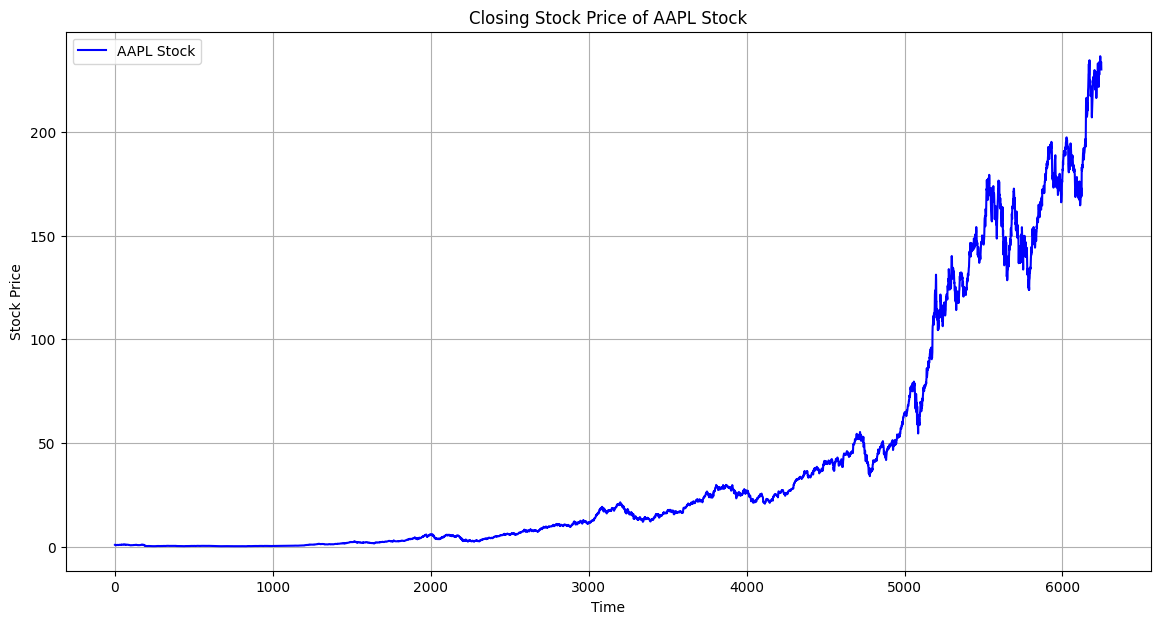

In [5]:
plt.figure(figsize=(14, 7))
plt.plot(range(len(total_data)), total_data, label='AAPL Stock', color='blue', linewidth=1.5)
plt.title('Closing Stock Price of AAPL Stock')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid()
plt.show()

Min-Max Normalization with **MinMaxScaler**

In [6]:
sc = MinMaxScaler(feature_range=(0, 1))
train_scaled = sc.fit_transform(train_set)
test_scaled = sc.transform(test_set)

**Sequence Creation**

In [7]:
def create_sequences(data, seq_length=60):
    x = []
    y = []
    for i in range(seq_length, len(data)):
        x.append(data[i-seq_length:i, 0].reshape(1,seq_length))
        y.append(data[i, 0].reshape(-1))
    return np.array(x), np.array(y)
X_train, y_train = create_sequences(train_scaled, seq_length)
X_test, y_test = create_sequences(test_scaled, seq_length)

In [8]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [9]:
'''
Creating DataLoaders for training and testing
'''
train_loader = torch.utils.data.DataLoader(list(zip(X_train, y_train)), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(list(zip(X_test, y_test)), batch_size=batch_size, shuffle=False)

**Training Function**

In [10]:
def train(model, train_loader, criterion, optimizer, verbose=1, num_epochs=100):
    model.train()
    model.to(device)
    history = []
    for epoch in range(num_epochs):
        total_loss = 0.0
        num_batches = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            num_batches += 1
        average_loss = total_loss / num_batches
        history.append(average_loss)
        if(verbose != 0):
          print(f"Epoch {epoch+1}/{num_epochs}, Loss: {average_loss:.6f}")
    return history

In [11]:
def test(model, test_loader):
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)

            predictions.extend(outputs.cpu().detach().numpy())
            true_labels.extend(labels.cpu().detach().numpy())

    return np.array(predictions), np.array(true_labels)

In [12]:
input_size = 60
hidden_size = 128
num_layers = 1
epoch = 100

Importing Models

In [38]:
file_id = ['1eeYM_FPaTuF45W-K3L8EAZP7ww1V_Ikg','1g97qqnicf8KmwKdcF2meWCnSszg21upW','1N7b_VBZeY2CcSeQ6O2U3L5J2Zn-CfDCN']
for id in file_id:
  !gdown -q "https://drive.google.com/uc?id={id}"

In [14]:
from LSTM_Models import AMVLSTM, LSTM, VLSTM

LSTM

In [15]:
np.random.seed(42)
torch.manual_seed(42)
model = LSTM(input_size, hidden_size, num_layers).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [16]:
history = train(model,train_loader,criterion,optimizer,verbose=0,num_epochs=epoch)

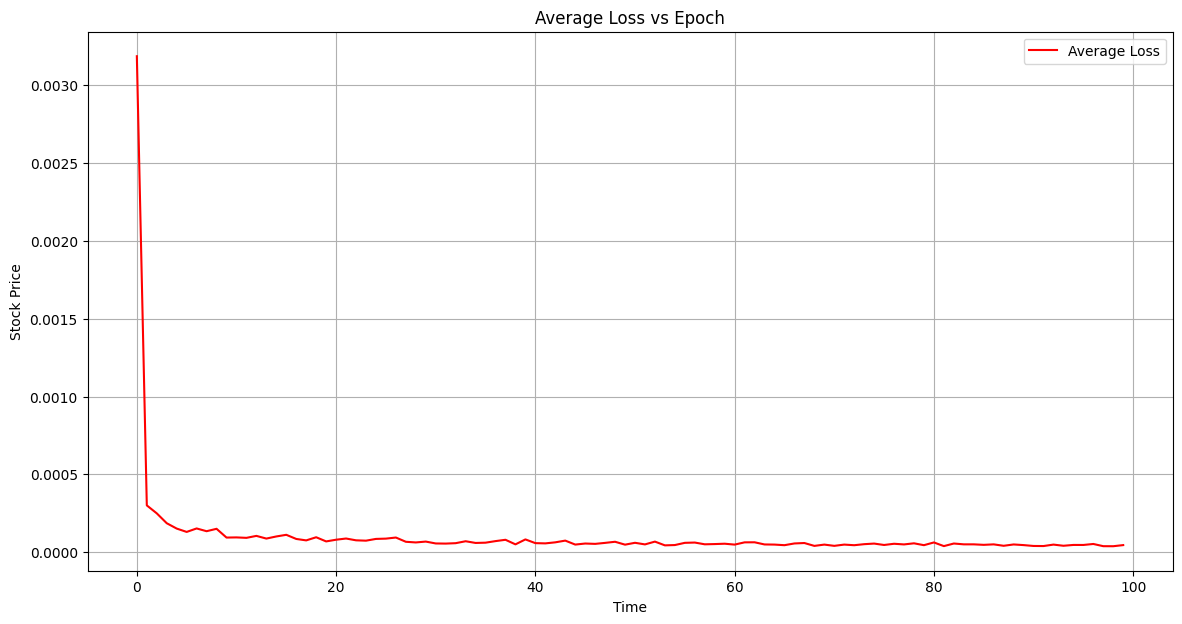

In [17]:
plt.figure(figsize=(14, 7))
plt.plot(range(len(history)), history, label='Average Loss', color='red', linewidth=1.5)
plt.title('Average Loss vs Epoch')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid()
plt.show()

In [18]:
y_pred, y_true = test(model,test_loader)
y_pred = sc.inverse_transform(y_pred)
y_true = sc.inverse_transform(y_true)

In [19]:
r2_LSTM = r2_score(y_true, y_pred)
MSE_LSTM = mean_squared_error(y_true, y_pred)
MAE_LSTM = mean_absolute_error(y_true, y_pred)
print("+" + "-"*20 + "+" + "-"*15 + "+" + "-"*15 + "+" + "-"*15 + "+")
print("| {:<18} | {:<13} | {:<13} | {:<13} |".format("Model", "R2 Score", "MSE", "MAE"))
print("+" + "-"*20 + "+" + "-"*15 + "+" + "-"*15 + "+" + "-"*15 + "+")
print("| {:<18} | {:<13.4f} | {:<13.4f} | {:<13.4f} |".format("LSTM", r2_LSTM, MSE_LSTM, MAE_LSTM))
print("+" + "-"*20 + "+" + "-"*15 + "+" + "-"*15 + "+" + "-"*15 + "+")

+--------------------+---------------+---------------+---------------+
| Model              | R2 Score      | MSE           | MAE           |
+--------------------+---------------+---------------+---------------+
| LSTM               | 0.7192        | 209.1312      | 10.8942       |
+--------------------+---------------+---------------+---------------+


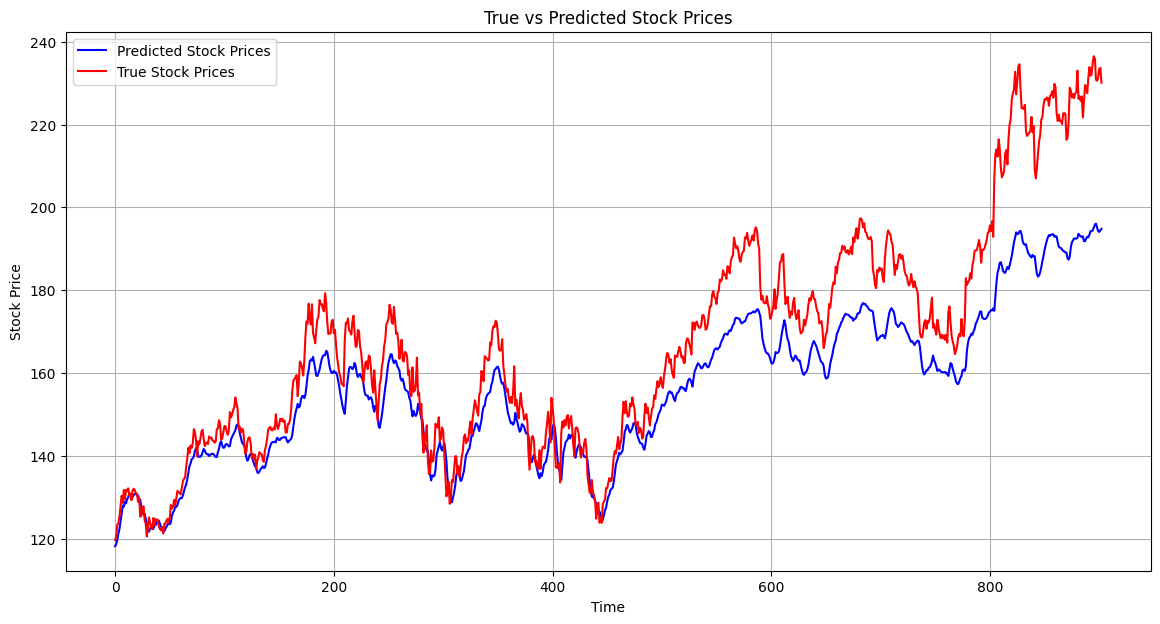

In [20]:
plt.figure(figsize=(14, 7))
plt.plot(range(len(y_pred)), y_pred, label='Predicted Stock Prices', color='blue', linewidth=1.5)
plt.plot(range(len(y_true)), y_true, label='True Stock Prices', color='red', linewidth=1.5)
plt.title('True vs Predicted Stock Prices')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid()
plt.show()

Variational LSTM

In [21]:
np.random.seed(42)
torch.manual_seed(42)
model = VLSTM(input_size, hidden_size, num_layers).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [22]:
history = train(model,train_loader,criterion,optimizer,verbose=0,num_epochs=epoch)

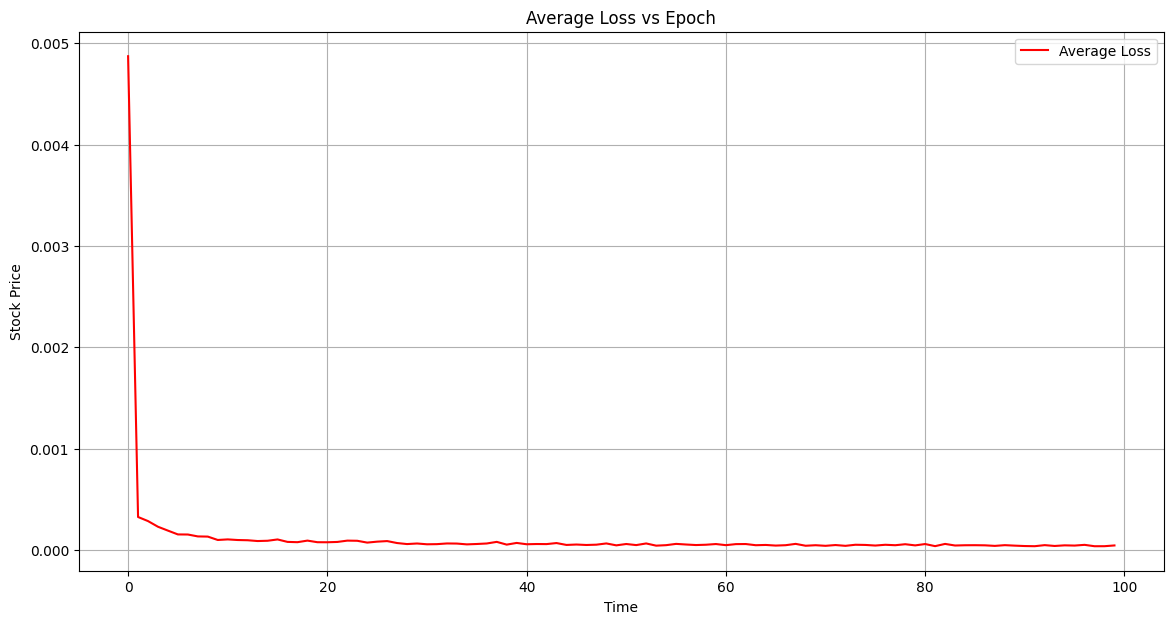

In [23]:
plt.figure(figsize=(14, 7))
plt.plot(range(len(history)), history, label='Average Loss', color='red', linewidth=1.5)
plt.title('Average Loss vs Epoch')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid()
plt.show()

In [24]:
y_pred, y_true = test(model,test_loader)
y_pred = sc.inverse_transform(y_pred)
y_true = sc.inverse_transform(y_true)

In [25]:
r2_VLSTM = r2_score(y_true, y_pred)
MSE_VLSTM = mean_squared_error(y_true, y_pred)
MAE_VLSTM = mean_absolute_error(y_true, y_pred)
print("+" + "-"*20 + "+" + "-"*15 + "+" + "-"*15 + "+" + "-"*15 + "+")
print("| {:<18} | {:<13} | {:<13} | {:<13} |".format("Model", "R2 Score", "MSE", "MAE"))
print("+" + "-"*20 + "+" + "-"*15 + "+" + "-"*15 + "+" + "-"*15 + "+")
print("| {:<18} | {:<13.4f} | {:<13.4f} | {:<13.4f} |".format("Vatiational LSTM", r2_VLSTM, MSE_VLSTM, MAE_VLSTM))
print("+" + "-"*20 + "+" + "-"*15 + "+" + "-"*15 + "+" + "-"*15 + "+")

+--------------------+---------------+---------------+---------------+
| Model              | R2 Score      | MSE           | MAE           |
+--------------------+---------------+---------------+---------------+
| Vatiational LSTM   | 0.7186        | 209.5548      | 10.8976       |
+--------------------+---------------+---------------+---------------+


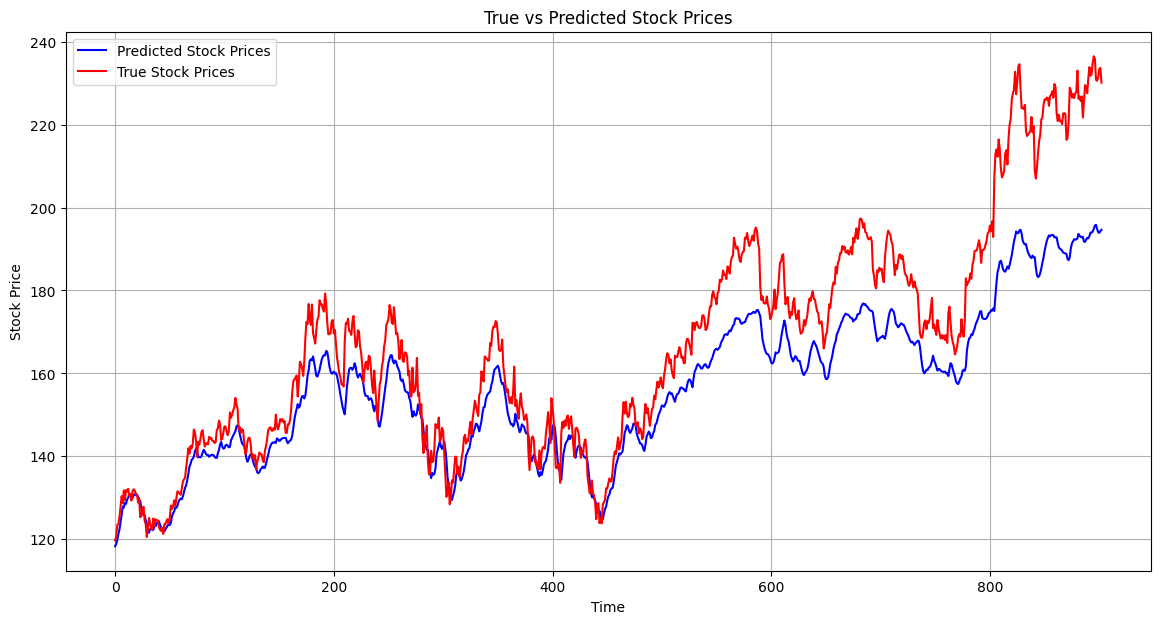

In [26]:
plt.figure(figsize=(14, 7))
plt.plot(range(len(y_pred)), y_pred, label='Predicted Stock Prices', color='blue', linewidth=1.5)
plt.plot(range(len(y_true)), y_true, label='True Stock Prices', color='red', linewidth=1.5)
plt.title('True vs Predicted Stock Prices')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid()
plt.show()

Attention Mechanism Variational LSTM

In [27]:
np.random.seed(42)
torch.manual_seed(42)
model = AMVLSTM(input_size, hidden_size, num_layers).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [28]:
history = train(model,train_loader,criterion,optimizer,verbose=0,num_epochs=epoch)

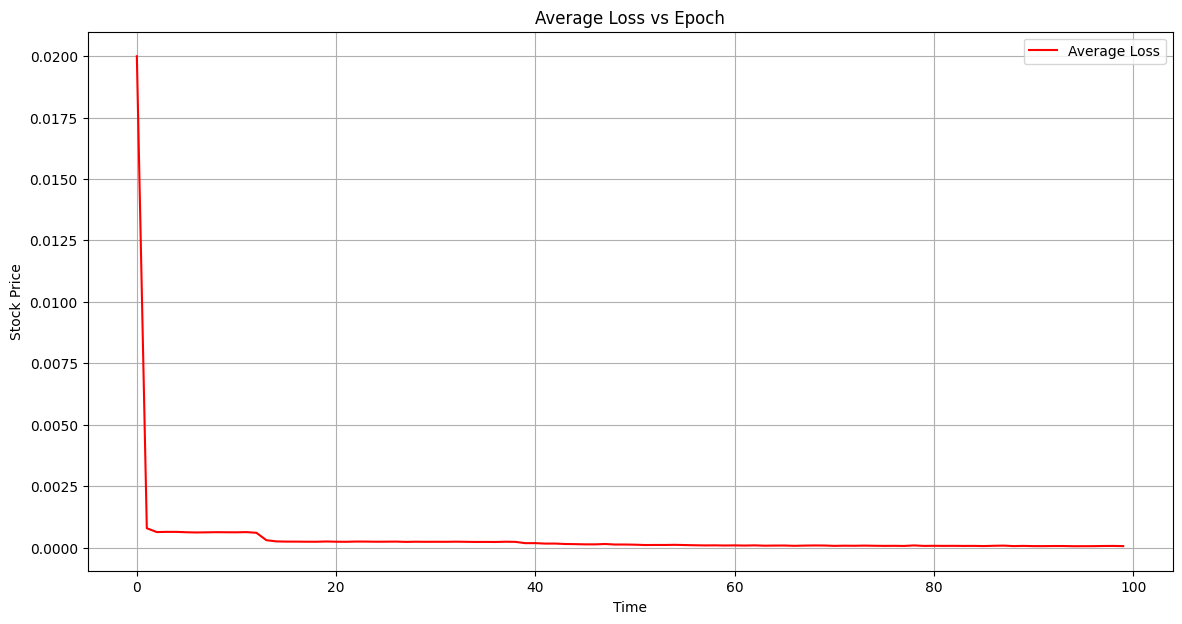

In [29]:
plt.figure(figsize=(14, 7))
plt.plot(range(len(history)), history, label='Average Loss', color='red', linewidth=1.5)
plt.title('Average Loss vs Epoch')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid()
plt.show()

In [30]:
y_pred, y_true = test(model,test_loader)
y_pred = sc.inverse_transform(y_pred)
y_true = sc.inverse_transform(y_true)

In [31]:
r2_ALSTM = r2_score(y_true, y_pred)
MSE_ALSTM = mean_squared_error(y_true, y_pred)
MAE_ALSTM = mean_absolute_error(y_true, y_pred)
print("+" + "-"*20 + "+" + "-"*15 + "+" + "-"*15 + "+" + "-"*15 + "+")
print("| {:<18} | {:<13} | {:<13} | {:<13} |".format("Model", "R2 Score", "MSE", "MAE"))
print("+" + "-"*20 + "+" + "-"*15 + "+" + "-"*15 + "+" + "-"*15 + "+")
print("| {:<18} | {:<13.4f} | {:<13.4f} | {:<13.4f} |".format("AMV-LSTM", r2_ALSTM, MSE_ALSTM, MAE_ALSTM))
print("+" + "-"*20 + "+" + "-"*15 + "+" + "-"*15 + "+" + "-"*15 + "+")

+--------------------+---------------+---------------+---------------+
| Model              | R2 Score      | MSE           | MAE           |
+--------------------+---------------+---------------+---------------+
| AMV-LSTM           | 0.9547        | 33.7398       | 4.5808        |
+--------------------+---------------+---------------+---------------+


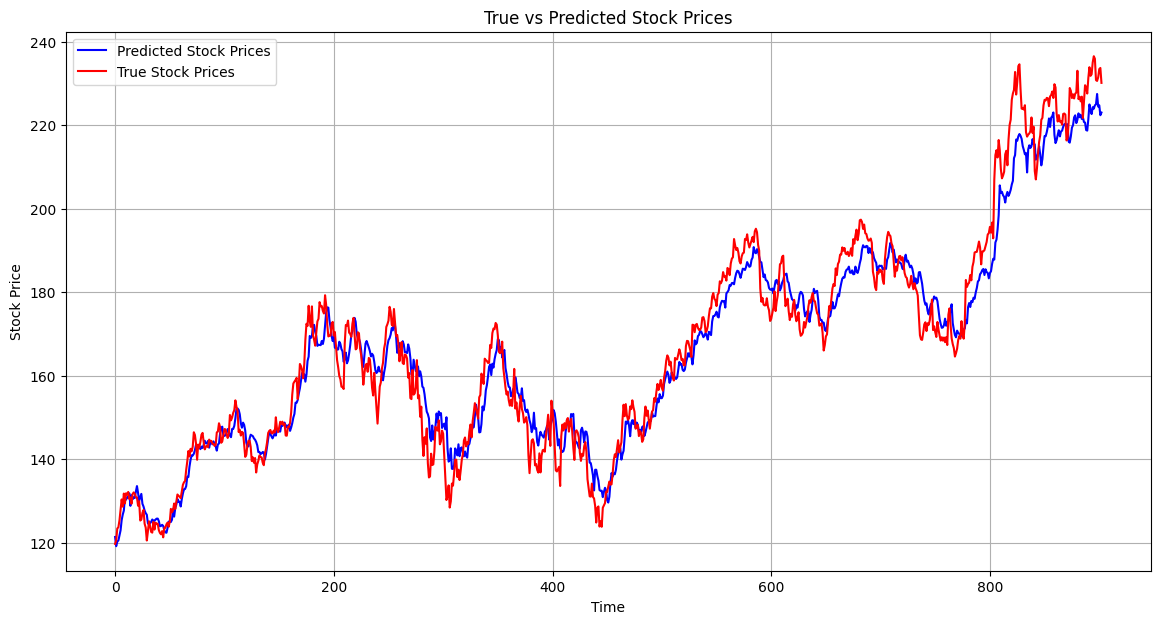

In [32]:
plt.figure(figsize=(14, 7))
plt.plot(range(len(y_pred)), y_pred, label='Predicted Stock Prices', color='blue', linewidth=1.5)
plt.plot(range(len(y_true)), y_true, label='True Stock Prices', color='red', linewidth=1.5)
plt.title('True vs Predicted Stock Prices')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid()
plt.show()

Comparison

In [40]:
total_width = 40
print(" " * ((total_width - 23) // 2) + "+" + "-" * 20 + "+" + "-" * 15 + "+" + "-" * 15 + "+" + "-" * 15 + "+")
print(" " * ((total_width - 23) // 2) + "| {:<18} | {:<13} | {:<13} | {:<13} |".format("Model", "R2 Score", "MSE", "MAE"))
print(" " * ((total_width - 23) // 2) + "+" + "-" * 20 + "+" + "-" * 15 + "+" + "-" * 15 + "+" + "-" * 15 + "+")
print(" " * ((total_width - 23) // 2) + "| {:<18} | {:<13.4f} | {:<13.4f} | {:<13.4f} |".format("LSTM", r2_LSTM, MSE_LSTM, MAE_LSTM))
print(" " * ((total_width - 23) // 2) + "+" + "-" * 20 + "+" + "-" * 15 + "+" + "-" * 15 + "+" + "-" * 15 + "+")
print(" " * ((total_width - 23) // 2) + "| {:<18} | {:<13.4f} | {:<13.4f} | {:<13.4f} |".format("Variational LSTM", r2_VLSTM, MSE_VLSTM, MAE_VLSTM))
print(" " * ((total_width - 23) // 2) + "+" + "-" * 20 + "+" + "-" * 15 + "+" + "-" * 15 + "+" + "-" * 15 + "+")
print(" " * ((total_width - 23) // 2) + "| {:<18} | {:<13.4f} | {:<13.4f} | {:<13.4f} |".format("AMV-LSTM", r2_ALSTM, MSE_ALSTM, MAE_ALSTM))
print(" " * ((total_width - 23) // 2) + "+" + "-" * 20 + "+" + "-" * 15 + "+" + "-" * 15 + "+" + "-" * 15 + "+")

        +--------------------+---------------+---------------+---------------+
        | Model              | R2 Score      | MSE           | MAE           |
        +--------------------+---------------+---------------+---------------+
        | LSTM               | 0.7192        | 209.1312      | 10.8942       |
        +--------------------+---------------+---------------+---------------+
        | Variational LSTM   | 0.7186        | 209.5548      | 10.8976       |
        +--------------------+---------------+---------------+---------------+
        | AMV-LSTM           | 0.9547        | 33.7398       | 4.5808        |
        +--------------------+---------------+---------------+---------------+
